# Exercice 2

In [1]:
import numpy as np
import pandas as pd
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

import random
import os
import cv2

import seaborn as sns
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras import models, layers
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score

## Definition des constantes

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
DOGS_FILES_ROOT_DIR = "../../data/cats_dogs/"

In [4]:
filenames = os.listdir(DOGS_FILES_ROOT_DIR)
categories = ['dog' if name.startswith('dog') else 'cat' for name in filenames]

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
# categories

In [6]:
# df[df["category"] == "dog"]

<Axes: xlabel='category'>

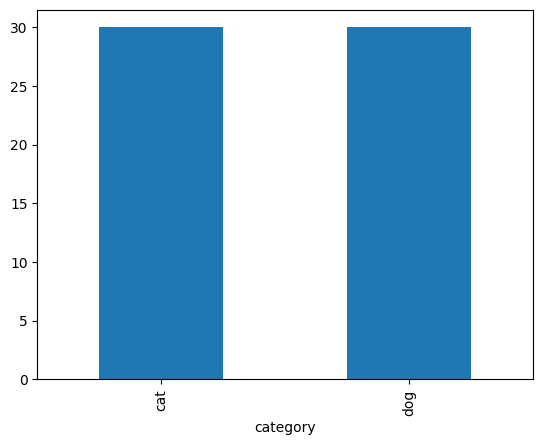

In [7]:
df['category'].value_counts().plot.bar()

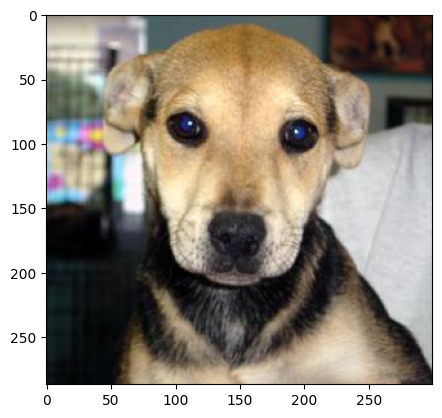

In [8]:
sample = random.choice(filenames)
image = load_img(DOGS_FILES_ROOT_DIR + sample)
plt.imshow(image)

# Création du modèle

Nous définissons l'architecture du CNN comme suit:
Soit une image de dimension IMAGE_SIZE
Une premiere couche composer de 32 filtres de taille 3 * 3, de maxpoling de taille 2 * 2, une dropout de 0.25 et une fonction d'actvation relu.

Une premiere couche composer de 70 filtres de taille 3 * 3, de maxpoling de taille 2 * 2, une dropout de 0.25 et une fonction d'actvation relu.

Une premiere couche composer de 128 filtres de taille 3 * 3, de maxpoling de taille 2 * 2, une dropout de 0.25 et une fonction d'actvation relu.

Une premiere couche composer de 512 filtres de taille 3 * 3, de maxpoling de taille 2 * 2, une dropout de 0.25 et une fonction d'actvation relu.

Une premiere couche composer de 512 filtres de taille 3 * 3, de maxpoling de taille 2 * 2, une dropout de 0.25 et une fonction d'actvation relu.

Une couche de  sortie avec  fonction d'actvation softmax.


In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # 1er bloc conv
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(70, (3, 3), activation='relu'),  # 2e bloc conv
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),  # 3e bloc conv
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu'),  # 4e bloc conv
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu'),  # 5e bloc conv
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(1, activation='sigmoid')  # Sortie binaire
])


c:\Users\Admin\Documents\DIT Courses\DL\exam\projet-deeplearning\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:

# Résumé du modèle
# model.summary()

In [11]:
# Compilation du modèle
# model.compile(
#     loss='binary_crossentropy',  # <== Pour classification binaire
#     optimizer='adam',
#     metrics=['accuracy']
# )


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 🔀 Split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 🧪 Générateurs
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, DOGS_FILES_ROOT_DIR,
    x_col='filename', y_col='category',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=32
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df, DOGS_FILES_ROOT_DIR,
    x_col='filename', y_col='category',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=32
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, DOGS_FILES_ROOT_DIR,
    x_col='filename', y_col='category',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 43 validated image filenames belonging to 2 classes.
Found 11 validated image filenames belonging to 2 classes.
Found 6 validated image filenames belonging to 2 classes.


In [13]:
from sklearn.utils.class_weight import compute_class_weight

y = train_df['category'].map({'cat': 0, 'dog': 1})
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y
)

In [14]:
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

# 📦 Transfer learning avec MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# On ne fine-tune que les dernières couches
for layer in base_model.layers:
    layer.trainable = False


In [15]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# 🔁 Entraînement
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight={0: class_weights[0], 1: class_weights[1]}
)

c:\Users\Admin\Documents\DIT Courses\DL\exam\projet-deeplearning\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3235 - loss: 0.9725 - val_accuracy: 0.6364 - val_loss: 0.6843
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4145 - loss: 0.8945 - val_accuracy: 0.6364 - val_loss: 0.6754
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.4043 - loss: 0.8997 - val_accuracy: 0.6364 - val_loss: 0.6682
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.3538 - loss: 0.8653 - val_accuracy: 0.6364 - val_loss: 0.6624
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.3939 - loss: 0.9018 - val_accuracy: 0.5455 - val_loss: 0.6561
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5078 - loss: 0.7859 - val_accuracy: 0.5455 - val_loss: 0.6491
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3731 - loss: 0.8350 - val_accuracy: 0.5455 - val_loss: 0.6421
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5649 - loss: 0.7426 - val_accuracy: 0.5455 - val_loss: 0.

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
y_true = test_generator.classes

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=["Cat", "Dog"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step
[[2 1]
 [1 2]]
              precision    recall  f1-score   support

         Cat       0.67      0.67      0.67         3
         Dog       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



In [18]:
# Sauvegarde au format .h5
model.save("../exo2/model/model.h5")

### Questions

Question 1 : Quelle est le type de cette classification?\
Question 2 : Implémenter le réseau convolutif\
Question 3 : Calculer le nombres de paramètres\
Question 4 : Quel rôle joue la méthode dropout dans un réseau de neurone convolitif\

In [19]:
model.count_params()

2259265

### Reponses

✅ Question 1 : Quelle est le type de cette classification ?
C'est une classification binaire.